# Stree view house number

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.plots import *
import pandas as pd
from fastai.conv_learner import *
from fastai.dataset import *

In [3]:
ls /fast/data/SVHN

extra/            models/          test.tar.gz      train_length.csv
extra_boxes.csv   test/            tmp/             train.tar.gz
extra.csv         test_boxes.csv   train/
extra_length.csv  test.csv         train_boxes.csv
extra.tar.gz      test_length.csv  train.csv


In [4]:
home_dir = '/fast/data/SVHN/'

In [5]:
train_df = pd.read_csv(os.path.join(home_dir, 'test.csv'))

In [6]:
max([len(l.split(' ')) for l in list(train_df.tags)])

5

In [7]:
train_df.sample(3)

,image_name,tags
12917,9863,4 5
4461,2251,2 1
7771,5230,2 2


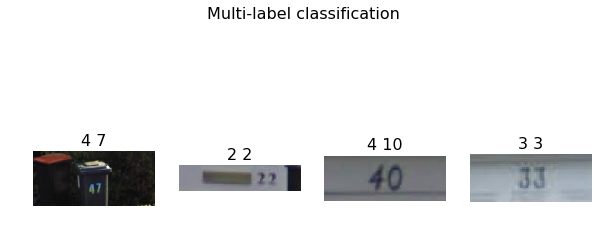

In [8]:
samples = train_df.sample(4)
list_paths = [f"{home_dir}test/{i}.png" for i in list(samples['image_name'])]
titles=list(samples['tags'])
plots_from_files(list_paths, titles=titles, maintitle="Multi-label classification")

In [9]:
f_model = resnet34

In [10]:
label_csv = os.path.join(home_dir, 'test.csv')
bb_csv = os.path.join(home_dir, 'test_boxes.csv')
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n, val_pct=0.2)

In [11]:
train_df = pd.read_csv(label_csv)
train_df['tags'] = train_df.tags.apply(lambda x: [int(i) if int(i) != 10 else 0 for i in x.split(' ')])

In [12]:
((val_label,trn_label),) = split_by_idx(val_idxs, train_df)

In [13]:
def get_data(sz, bs=30):
    # don't use data augumented in test set.
    aug_tfms = []
    tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=aug_tfms)
    return ImageClassifierData.from_csv(home_dir, 'test', bb_csv, tfms=tfms, bs=bs, 
                                        suffix='.png', test_name='test', 
                                        continuous=True, num_workers=4)

In [14]:
sz = 256
data = get_data(sz)

In [15]:
x, y = data.trn_ds[0]

In [16]:
x.shape, y

((3, 256, 256),
 array([ 89.,  48., 180.,  64.,  89.,  77., 180., 108.], dtype=float32))

In [17]:
from matplotlib import patches, patheffects
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)
    
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

def get_big_bounding_box(boxes):
    # top, left, bottom, right
    return np.array([min(boxes[:, 0]), min(boxes[:,1]), max(boxes[:, 2]), max(boxes[:, 3])])

def draw_im(im, boxes, cats, draw_one_box=False):
    ax = show_img(im, figsize=(8,4))
    if draw_one_box:
        b = bb_hw(boxes)
        draw_rect(ax, b)
    else:
        for b, c in zip(boxes, cats):
            b = bb_hw(b)
            draw_rect(ax, b)
            draw_text(ax, b[:2], c, sz=16)

In [18]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, labels, sz):
        self.ds,self.labels = ds,labels
        self.sz = ds.sz
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x, y = self.ds[i]
        boxes = y.reshape((-1, 4))
        box = get_big_bounding_box(boxes) / sz
        return (x, ((len(self.labels[i])-1), box, np.array(self.labels[i])))

In [19]:
trn_ds2 = ConcatLblDataset(data.trn_ds, list(trn_label.tags), sz)
data.trn_dl.dataset = trn_ds2

In [20]:
x, y = data.trn_ds[4]
print(x.shape, y)

(3, 256, 256) (1, array([0.40625, 0.45703, 0.76172, 0.55859], dtype=float32), array([6, 0]))


(0, array([0.13281, 0.41797, 0.78516, 0.60156], dtype=float32), array([3]))


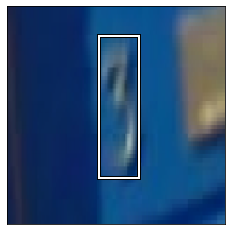

In [21]:
x, y = data.trn_ds[107]
img = data.trn_ds.ds.denorm(to_np(x))[0]
boxes = y[1] * sz
draw_im(img, boxes, y[1], draw_one_box=True)
print(y)

In [22]:
class CountHead(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.adaptive = AdaptiveConcatPool2d((2,2))
        self.flatten = Flatten()
        self.layer1 = nn.Sequential(nn.Dropout(p=0.2), nn.Linear(n, 1024), nn.BatchNorm1d(1024), nn.ReLU())
        self.layer2 = nn.Sequential(nn.Linear(1024, 512), nn.BatchNorm1d(512), nn.ReLU())
        self.layer31 = nn.Sequential(nn.Linear(512, 6))
        self.layer32 = nn.Sequential(nn.Linear(512, 4), nn.Sigmoid())
        self.layer33 = nn.Linear(512, 10 * 6)
    def forward(self, x):
        out = self.adaptive(x)
        out = self.flatten(out)
        out = self.layer1(out)
        out = self.layer2(out)
        label = self.layer31(out)
        box = self.layer32(out)
        nums = self.layer33(out).reshape(-1, 6, 10)
        return [label, box, nums]

In [23]:
def custome_accuracy(input:list, targs:list):
    "Compute accuracy with `targs` when `input` is bs * n_classes."
    input = input[0]
    targs = targs[0]
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    return (input==targs).float().mean()

def num_accuracy(pred:list, labels:list):
    "Compute accuracy with `targs` when `input` is bs * n_classes."
    n_sample = 0.0
    true_case = 0.0
    n_nums = pred[0].argmax(dim=1) + 1
    batch_size = pred[N_NUMBER_INDEX].shape[0]
    for i in range(batch_size):
        n_sample += 1
        pred_num = int(''.join([str(j.item()) for j in pred[NUMBER_INDEX][i][-n_nums[i]:].argmax(dim=1)]))
        true_num = int(''.join([str(j.item()) for j in labels[NUMBER_INDEX][i]]))
        if pred_num == true_num:
            true_case += 1
    return true_case / n_sample

In [24]:
count_head = CountHead(1024 * 4)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=count_head)
learn = ConvLearner(data, models, metrics=[custome_accuracy, num_accuracy])
learn.opt_fn = optim.Adam

In [25]:
NUMBER_INDEX = 2
N_NUMBER_INDEX= 0

In [26]:
# learn.summary()

In [27]:
ls /fast/data/SVHN/models

svhn_001.h5                     svhn_number_003_loop.h5
svhn_001_resnet32.h5            svhn_number_003_num_boost.h5
svhn_002.h5                     svhn_number_003_num_extra.h5
svhn_002_resnet32.h5            svhn_number_003_pool2_extra.h5
svhn_003.h5                     svhn_number_003_pool2.h5
svhn_003_resnet32.h5            svhn_number_003_pool3.h5
svhn_box_001.h5                 svhn_number_004.h5
svhn_box_002.h5                 svhn_number_004_loop.h5
svhn_box_003.h5                 svhn_number_004_num_boost.h5
svhn_box_004.h5                 svhn_number_004_num_extra.h5
svhn_number_001.h5              svhn_number_004_pool2_extra.h5
svhn_number_001_loop.h5         svhn_number_004_pool2.h5
svhn_number_001_pool2.h5        svhn_number_004_pool3.h5
svhn_number_001_pool3.h5        svhn_number_005.h5
svhn_number_002.h5              svhn_number_005_loop.h5
svhn_number_002_loop.h5         svhn_number_005_num_boost.h5
svhn_number_002_pool2_extra.h5  svhn_number_005_pool2.h5
svhn_number_00

In [28]:
learn.load('svhn_number_005_pool2')

In [30]:
def is_confidence(prob, THREADHOLD = 0.9):
    for i in prob:
        if i < THREADHOLD:
            False
    return True
wrong_images = dict()
for THREADHOLD in [0.5, 0.95, 0.99]:
    wrong_images[THREADHOLD] = list()
    n_sample = 0.0
    n_pass_thread_hold = 0.0
    true_case = 0.0
    learn.model.eval()
    with torch.no_grad():
        for images, labels in data.trn_dl:
            pred = learn.model(images)
            max_v, n_nums = nn.Softmax()(pred[N_NUMBER_INDEX]).max(dim=1)
            mark = max_v > THREADHOLD
            n_nums = n_nums + 1
            batch_size = pred[N_NUMBER_INDEX].shape[0]
            for i in range(batch_size):
                n_sample += 1
                prob, index = nn.Softmax()(pred[NUMBER_INDEX][i][-n_nums[i]:]).max(dim=1)
                if (mark[i] == 1) and is_confidence(prob, THREADHOLD):
                    n_pass_thread_hold += 1
                    pred_num = int(''.join([str(j.item()) for j in index]))
                    true_num = int(''.join([str(j.item()) for j in labels[NUMBER_INDEX][i]]))
                    if pred_num == true_num:
                        true_case += 1
#                     commend 2 lines below to save memory
#                     if pred_num != true_num:
#                          wrong_images[THREADHOLD].append((images[i], pred_num, true_num))
        print('THREADHOLD = ', THREADHOLD, 'Total case', n_sample, 'high confident cases: ', n_pass_thread_hold, 'Accuracy: ', true_case / n_pass_thread_hold * 100)

THREADHOLD =  0.5 Total case 10455.0 high confident cases:  10409.0 Accuracy:  61.715822845614376
THREADHOLD =  0.95 Total case 10455.0 high confident cases:  8520.0 Accuracy:  69.88262910798122
THREADHOLD =  0.99 Total case 10455.0 high confident cases:  7496.0 Accuracy:  74.19957310565634


In [ ]:
n = len(wrong_images[0.95])
import random
i = random.randint(0, n-1)
image, pred, true_num = wrong_images[0.95][i]
img = data.trn_ds.ds.denorm(to_np(image))[0]
show_img(img, figsize=(16,8))
print(pred, true_num)